In [1]:
using Optim, LsqFit
using Plots, StatsPlots, LaTeXStrings
using DelimitedFiles
using Statistics
using Turing
using DataFrames

In [2]:
pyplot(grid=:off)

Plots.PyPlotBackend()

In [3]:
ENV["COLUMNS"]=120
figdir = "figures/";

# Viral load data fitting

Data for influenza from


## Data set

10 mice with 13 data points each

In [4]:
tdata = Array(range(0., 12. , step=1.0))
data = readdlm("../../data/Smith2018/Virus_Best10.txt", ' ', Float64, '\n')
DataFrame(data, Symbol.(0.:12.))

10×13 DataFrame
 Row │ 0.0      1.0      2.0      3.0      4.0      5.0      6.0      7.0      8.0      9.0      10.0     11.0     12. ⋯
     │ Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Float64  Flo ⋯
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │     0.0  4.18551  5.67816  6.00515  5.9364   5.97712  5.44716  5.19848  4.00515      0.0      0.0      0.0      ⋯
   2 │     0.0  3.99136  5.47712  5.84488  5.82436  5.81012  5.0874   4.49136  0.0          0.0      0.0      0.0
   3 │     0.0  3.49136  5.44716  5.81012  5.83815  5.78016  5.2954   5.01851  2.94716      0.0      0.0      0.0
   4 │     0.0  3.29788  5.77233  6.24612  5.49136  5.9624   5.14412  5.51851  3.23882      0.0      0.0      0.0
   5 │     0.0  4.75515  5.9624   6.44716  5.78016  5.83244  5.99136  4.96982  0.0          0.0      0.0      0.0      ⋯
   6 │     0.0  4.30151  5.49136  6.86448  5.70812  5.80282  4.9624   4.47712  0.0          0.0      0.0      0.0
   7 │     0.0  3.49136  5.7954   5.74951  6.03148  5.82436  5.2954   5.17215  3.26036      0.0      0.0      0.0
   8 │     0.0  4.00515  6.03148  5.83815  6.26036  6.1294   5.18551  4.83815  0.0          0.0      0.0      0.0
   9 │     0.0  3.49136  6.18551  5.78784  5.59921  5.97712  5.34488  5.47712  0.0          0.0      0.0      0.0      ⋯
  10 │     0.0  4.50515  6.17215  6.03148  5.49136  5.34242  5.81012  5.01188  0.0          0.0      0.0      0.0
                                                                                                        1 column omitted

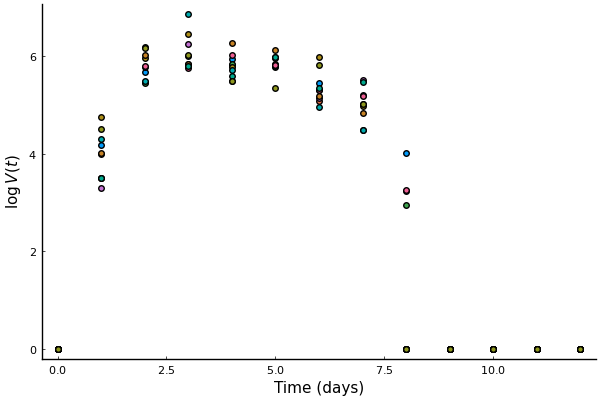

In [5]:
plt = plot(legend=:none, grid=:none, xlabel="Time (days)", ylabel=L"\log\,V(t)")
[plot!(tdata, data[i, :], seriestype=:scatter) for i in 1:size(data, 1)]
plt

## Standard virus load function

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

In [6]:
H(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
function v₁(t, a₁, a₂, logVmax)
    1. + (10^logVmax - 1.0)*(tanh(6.0*(t - (a₁ + a₂)/2)/abs(a₂ - a₁)) - tanh(-3.0*(a₂ + a₁)/abs(a₂ - a₁)))/2
end
function v₂(t, a₂, α) 
    1. - H(t - a₂) + H(t - a₂)*exp(-α*(t - a₂))
end
function v₃(t, b₁, b₂, logVmin)
    1. - (1.0 - 10^logVmin)*(tanh(6.0*(t - (b₁ + b₂)/2)/abs(b₂ - b₁)) - tanh(-3.0*(b₂ + b₁)/abs(b₂ - b₁)))/2
end
function LogVirusLoad(t, a₁, a₂, b₁, b₂, α, logVmax)
    θ = minimum(vvdata)
    logVmin = -6.0
    logV = log10(v₁(t, a₁, a₂, logVmax)*v₂(t, a₂, α)*v₃(t, b₁, b₂, logVmin))
    max(logV, θ)
end
par_names = ["a₁", "a₂", "b₁", "b₂", "α", "logVmax"];
cost(p) = sum(LogVirusLoad(ttdata, p) - vvdata).^2

cost (generic function with 1 method)

## Estimations errors

Construct estimation errors around each data point using MCMC.

This is only the error at the time centered at the average virus load curve.

Cons:

 - No variability per individual
 
 - No variability per parameter estimate

In [7]:
ttdata = repeat(tdata, inner=10)
tend = ttdata[end]
vvdata = reshape(data, 1, :)[:];
cost(p) = sum(abs2, LogVirusLoad.(ttdata, p...) - vvdata)

cost (generic function with 1 method)

Get a first estimate using optimization for the prior distributions

In [8]:
par0 = [0.10, 2.88, 6.00, 7.60, 0.20, 5.0]
lb   = [0.00, 1.00, 5.00, 7.00, 1e-8, 4.0]
ub   = [1.00, 5.00, 7.00, 9.00, 10.0, 7.0]
fit = optimize(cost, lb, ub, par0, SAMIN(), Optim.Options(iterations=10^5))

SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 52651

     Obj. value:     35.2616862604

       parameter      search width
         0.77223           0.00000 
         3.16121           0.00000 
         6.37968           0.00000 
         7.72606           0.00000 
         0.50320           0.00000 
         6.06687           0.00000 



 * Status: failure

 * Candidate solution
    Final objective value:     3.526169e+01

 * Found with
    Algorithm:     SAMIN

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    52651
    f(x) calls:    52651
    ∇f(x) calls:   0


In [9]:
sampler = PG(10); nsamples = 1000; nchains = 4;

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


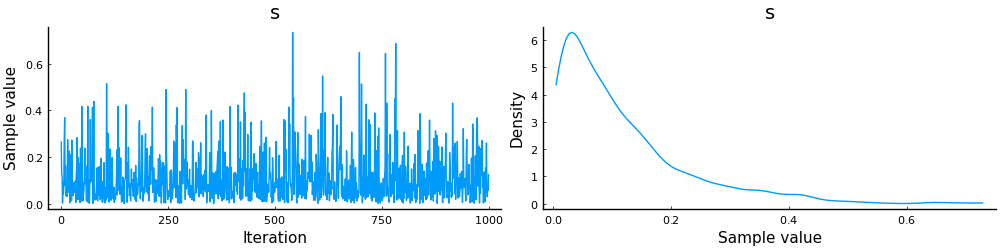

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


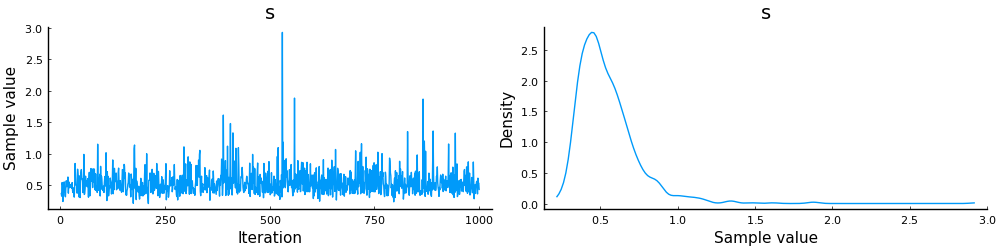

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


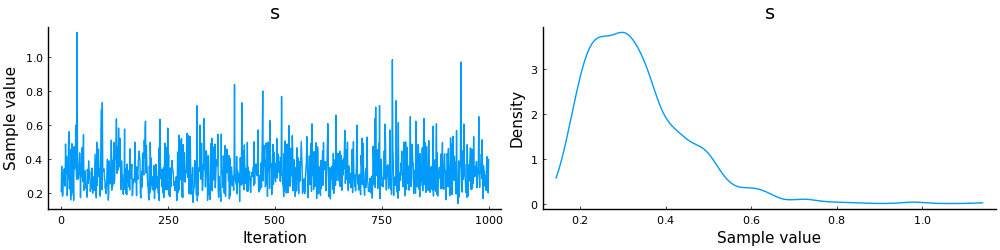

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


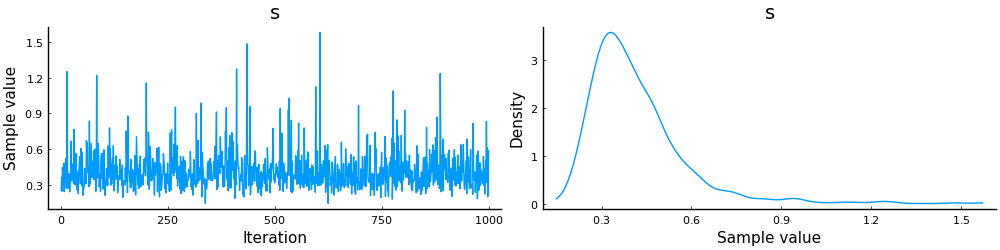

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


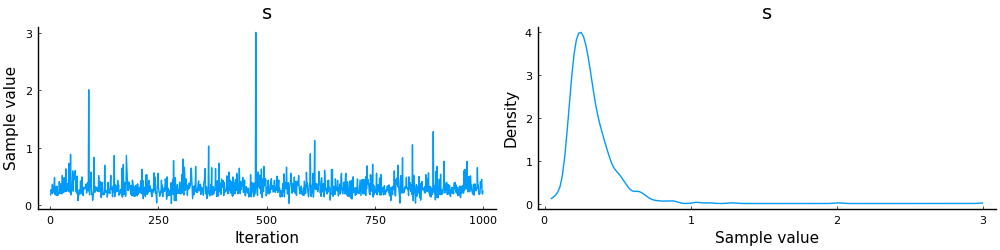

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


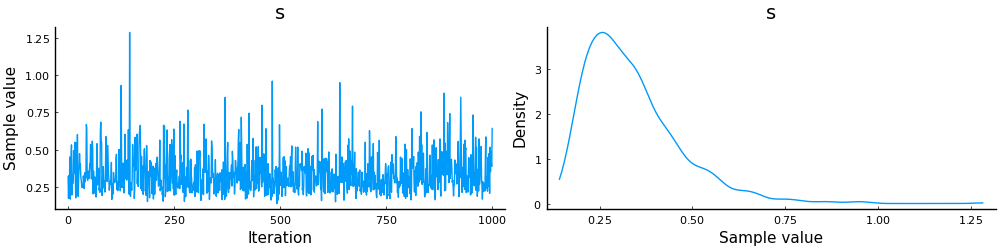

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


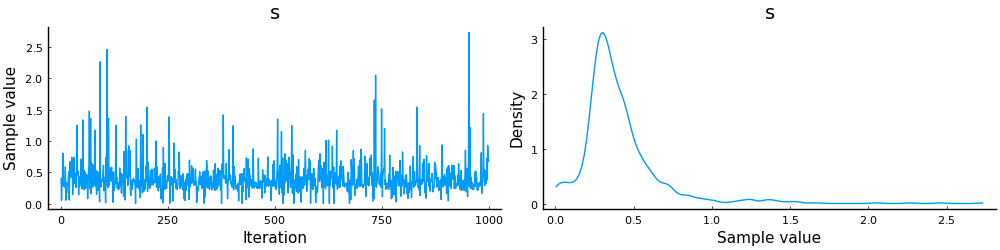

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


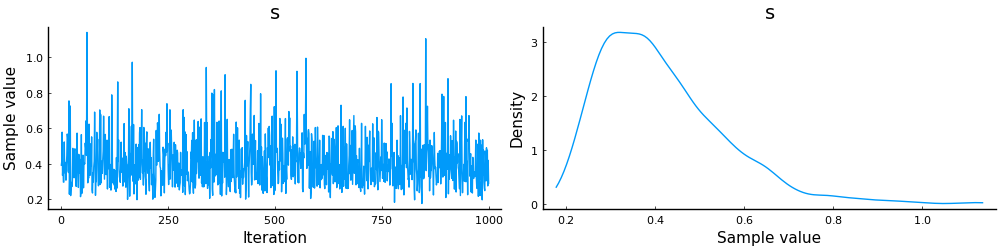

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


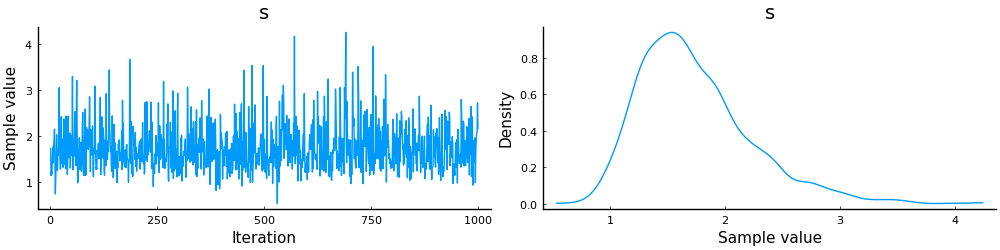

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


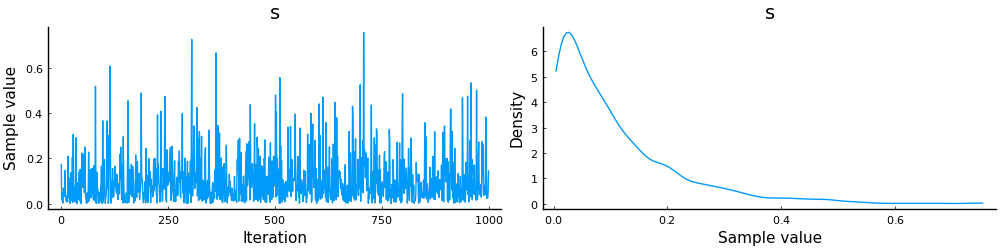

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


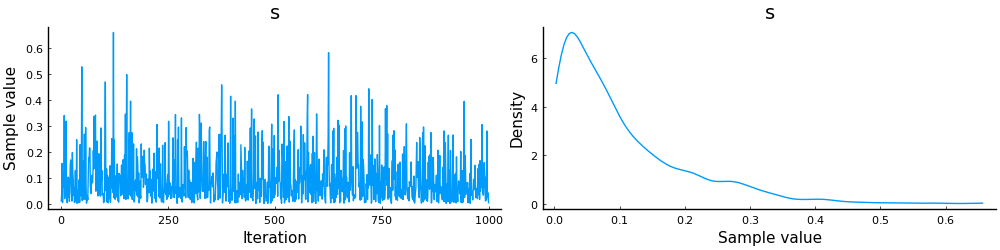

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


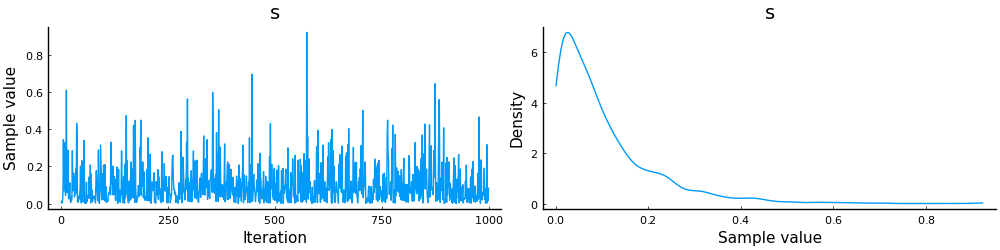

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


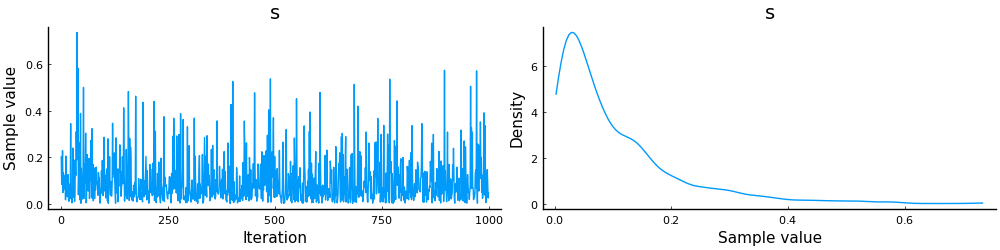

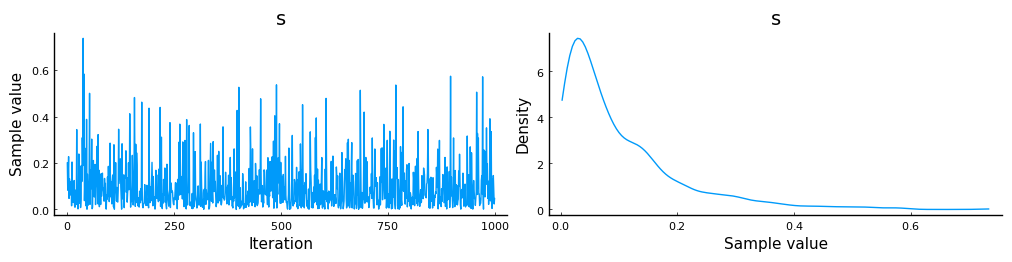

In [10]:
@model function errors_model(t, v, p)
    # one-time data with multiple observations
    s ~ Exponential(1.0)
    
    for i in eachindex(v)
        v[i] ~ Normal(LogVirusLoad(t, p...), s)
    end
end
err = zero(tdata)
# estimate errors for each time data point
for i in eachindex(tdata)
    chain = sample(errors_model(tdata[i], data[:, i], fit.minimizer), sampler, nsamples)
    err[i] = mean(chain[:s])
    display(plot(chain))
end

Plot error bars using 95% confidence interval

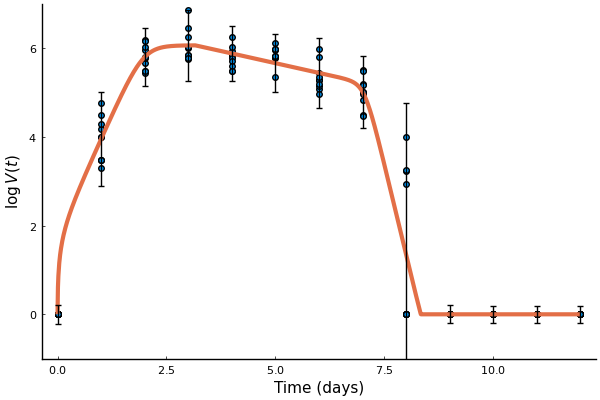

In [11]:
plot(ttdata, vvdata, seriestype=:scatter)
tt = [range(0., tend, step=1e-2);]
p = Optim.minimizer(fit)
vv = LogVirusLoad.(tt, p...)
plot!(tt, vv, lw=3)
tt = tdata
vv = LogVirusLoad.(tt, fit.minimizer...)
plot!(tt, vv, lw=0, yerr=1.96err)
plot!(legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 7)))

Now for only one individual (mice)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


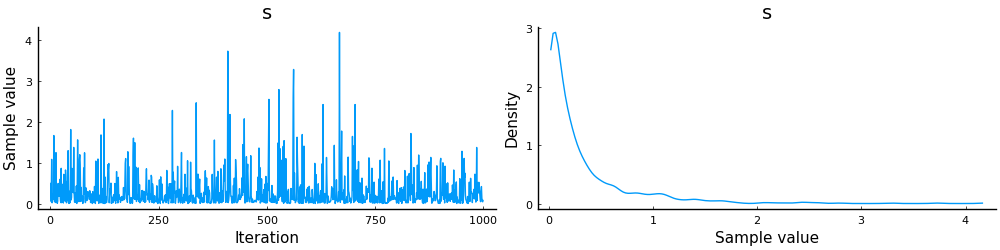

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


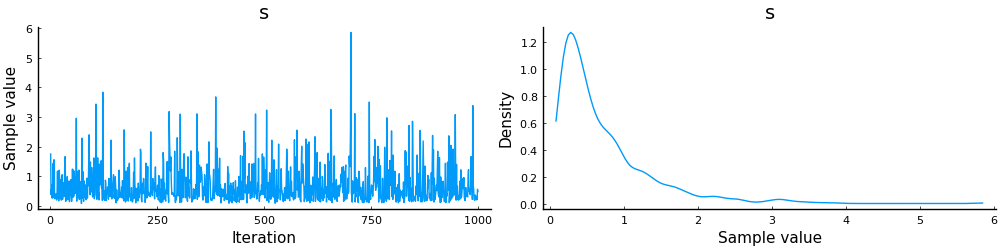

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


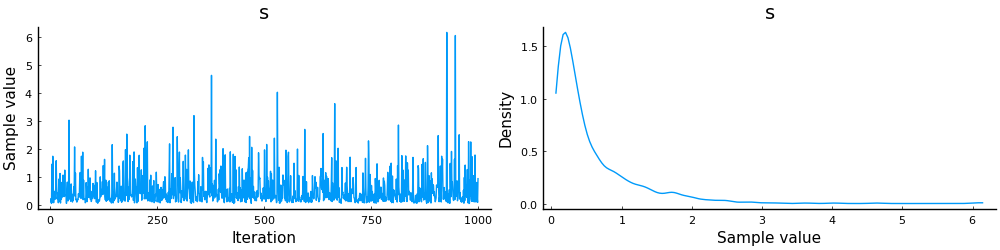

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


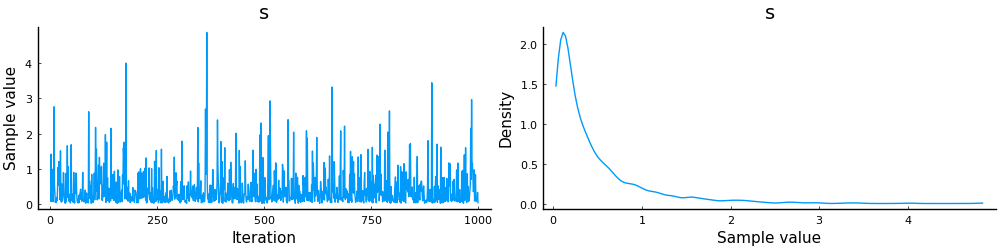

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


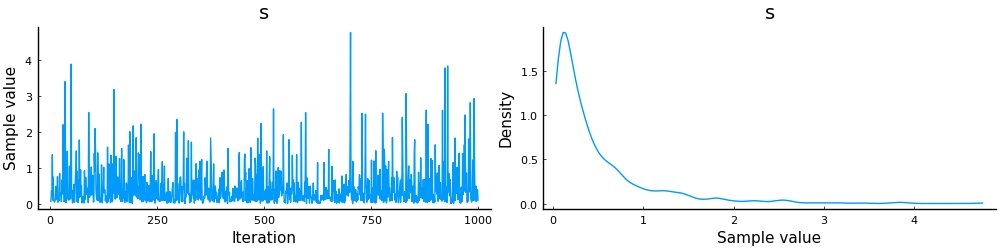

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


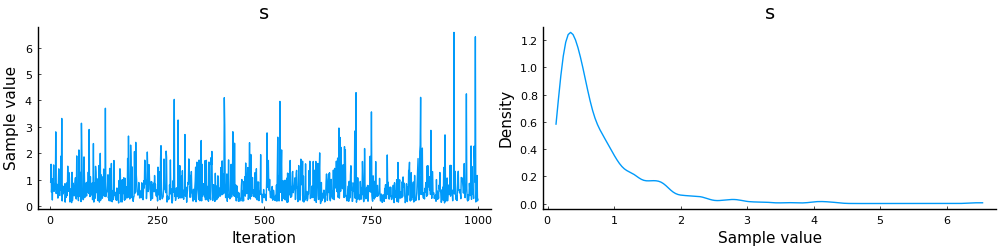

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


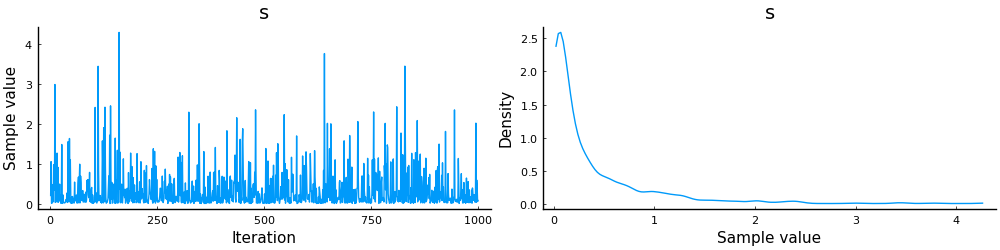

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


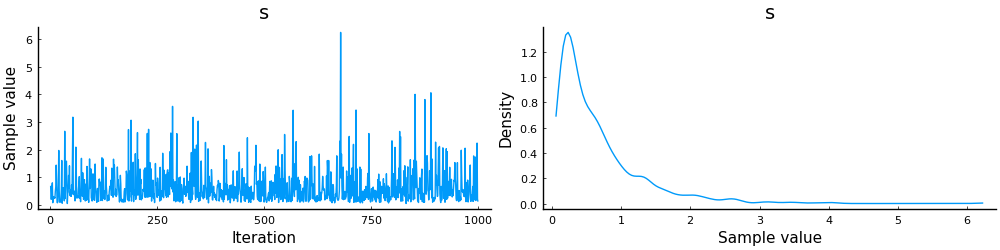

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


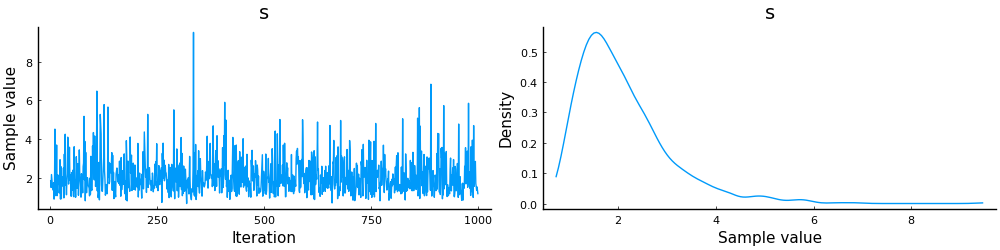

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


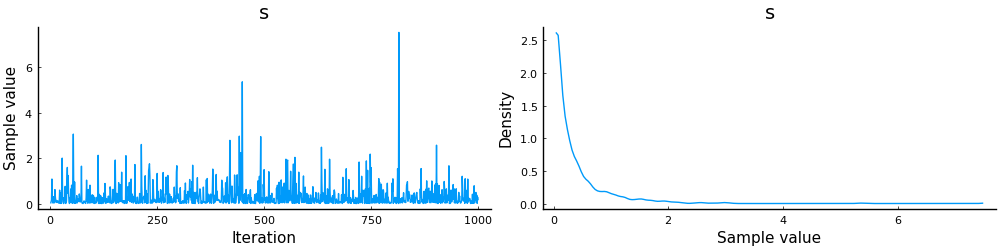

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


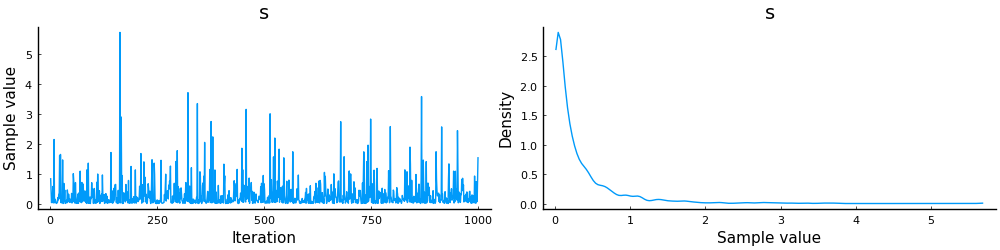

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


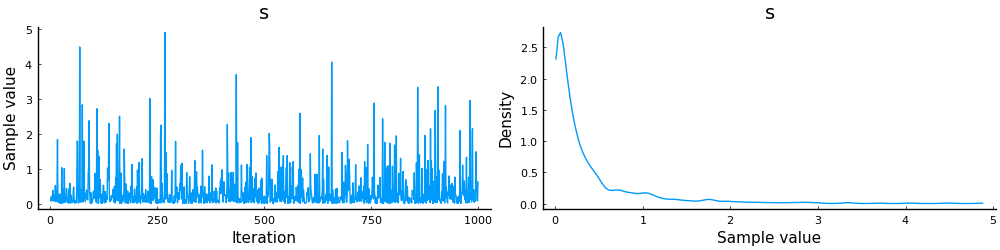

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


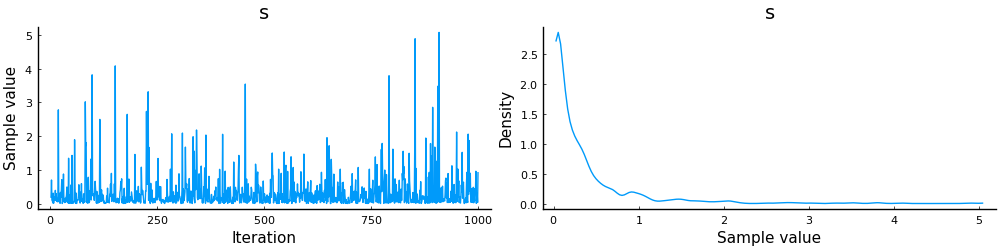

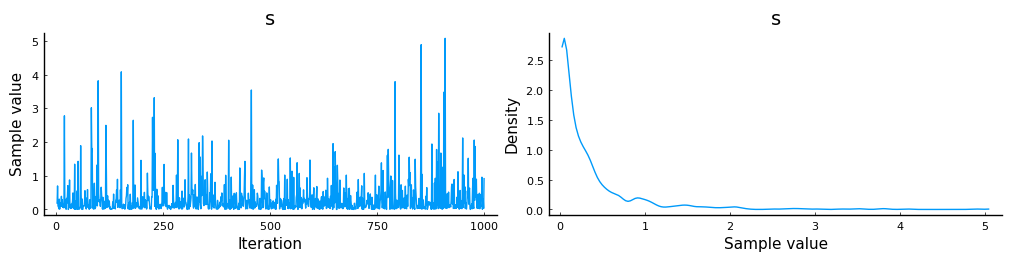

In [12]:
k = 1 # data_no. Mice number k
@model function errors_model(t, v)
    
    s ~ Exponential(1.0)
    
    for i in eachindex(v)
        v[i] ~ Normal(LogVirusLoad(t, fit.minimizer...), s)
    end
end
err = zero(tdata)
for i in eachindex(tdata)
    chain = sample(errors_model(tdata[i], data[k, i]), sampler, nsamples)
    err[i] = mean(chain[:s])
    display(plot(chain))
end

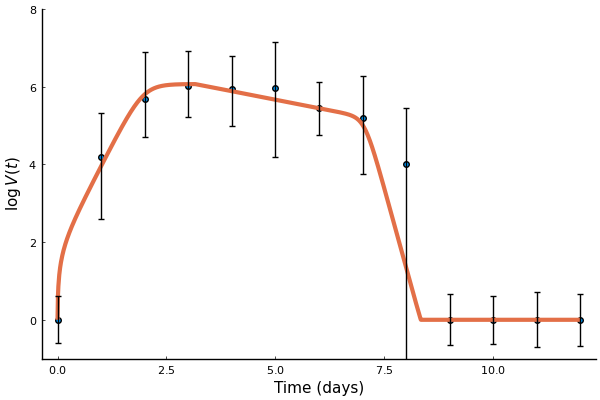

In [13]:
plot(tdata, data[k, :], seriestype=:scatter)
tt = [range(0., tend, step=1e-2);]
p = Optim.minimizer(fit)
vv = LogVirusLoad.(tt, p...)
plot!(tt, vv, lw=3)
tt = tdata
vv = LogVirusLoad.(tt, p...)
plot!(tt, vv, lw=0, yerr=1.96err)
plot!(legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 8)))

## Confidence intervals

Construct confidence intervals using MCMC and three approaches:

 a) Sample from the posterior distribution and model each parameter and independent variance for each time point.

 b) Sample from the predictive posterior distribution using a model each parameter and common variance for all time points.

 c) Sample from the posterios distributrion and model with the mixed-effect model (NL-MELSM). (TODO)

In [14]:
k = 1
ttdata = tdata
vvdata = data[k, :]
tend = ttdata[end]

12.0

### Sample from the posterior distribution and model each parameter and independent variance for each time point.

 - Variability per time
 
 - Prior distributions assume equal variability
 
 - Estimation per individual using population best estimate for the prior

In [15]:
@model function VLFmodel(t, v, p₀)
    # For each time point t[i], v[i] is a vector of observations
    # For now t and v have the same size, i.e. one obseravtion por time point
    tmax = maximum(t)
    # Prior distributions
    s ~ Exponential(1.0)
    a₁ ~ truncated(Normal(p₀[1], s), 0, p₀[3])
    a₂ ~ truncated(Normal(p₀[2], s), a₁, p₀[4])
    b₁ ~ truncated(Normal(p₀[3], s), a₂, tmax)
    b₂ ~ truncated(Normal(p₀[4], s), b₁, tmax)
    α ~ truncated(Normal(p₀[5], s), 0, Inf)
    logVmax ~ truncated(Normal(p₀[6], s), 0, Inf)
    σ ~ MvLogNormal(zero(t), s)
    # Model
    for i ∈ eachindex(v)
        v[i] ~ Normal(LogVirusLoad(t[i], a₁, a₂, b₁, b₂, α, logVmax), σ[i])
    end
    return v
end

VLFmodel (generic function with 1 method)

In [16]:
chains_prior = mapreduce(c -> sample(VLFmodel(ttdata, vvdata, fit.minimizer), 
                         Prior(), nsamples), chainscat, 1:nchains)
chains = mapreduce(c -> sample(VLFmodel(ttdata, vvdata, fit.minimizer), 
                   sampler, nsamples), chainscat, 1:nchains)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


Chains MCMC chain (1000×22×4 Array{Float64, 3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
parameters        = a₁, a₂, b₁, b₂, logVmax, s, α, σ[1], σ[2], σ[3], σ[4], σ[5], σ[6], σ[7], σ[8], σ[9], σ[10], σ[11], σ[12], σ[13]
internals         = logevidence, lp

Summary Statistics
  parameters        mean           std    naive_se        mcse         ess      rhat 
      Symbol     Float64       Float64     Float64     Float64     Float64   Float64 

          a₁      0.9073        0.7353      0.0116      0.0106   4091.2394    0.9998
          a₂      3.3239        0.7506      0.0119      0.0134   3914.8960    0.9996
          b₁      6.4750        0.7705      0.0122      0.0144   3936.1769    1.0000
          b₂      8.0175        0.7444      0.0118      0.0126   4024.5633    0.9995
     logVmax      6.1541        1.0002      0.0158      0.0175   3642.6064    0.9998
           s      0.6047        0.9762      0.0154      0.0

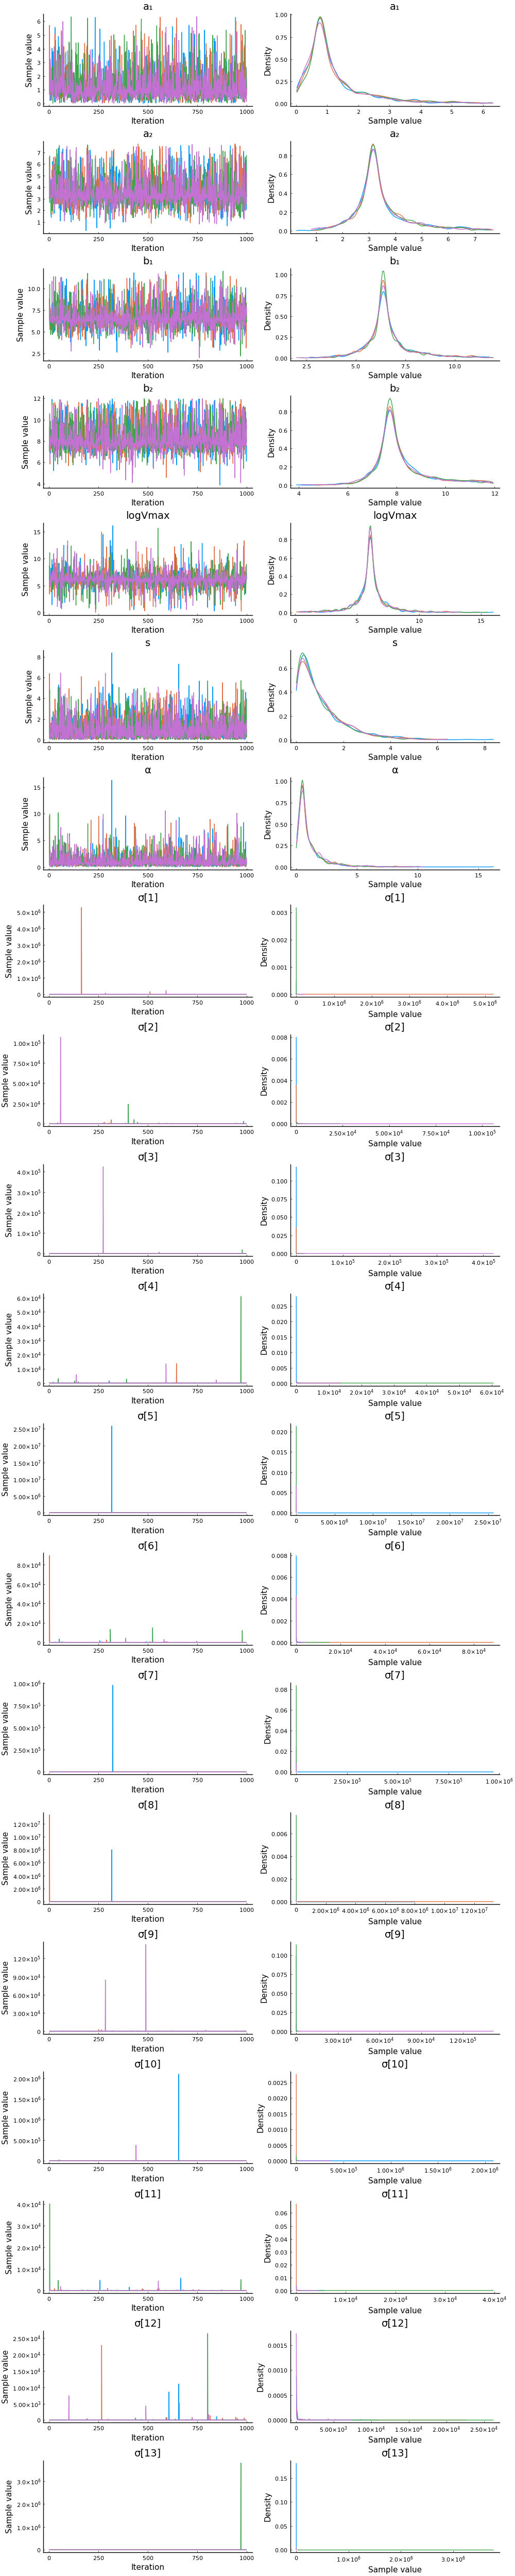

In [17]:
plot(chains_prior)

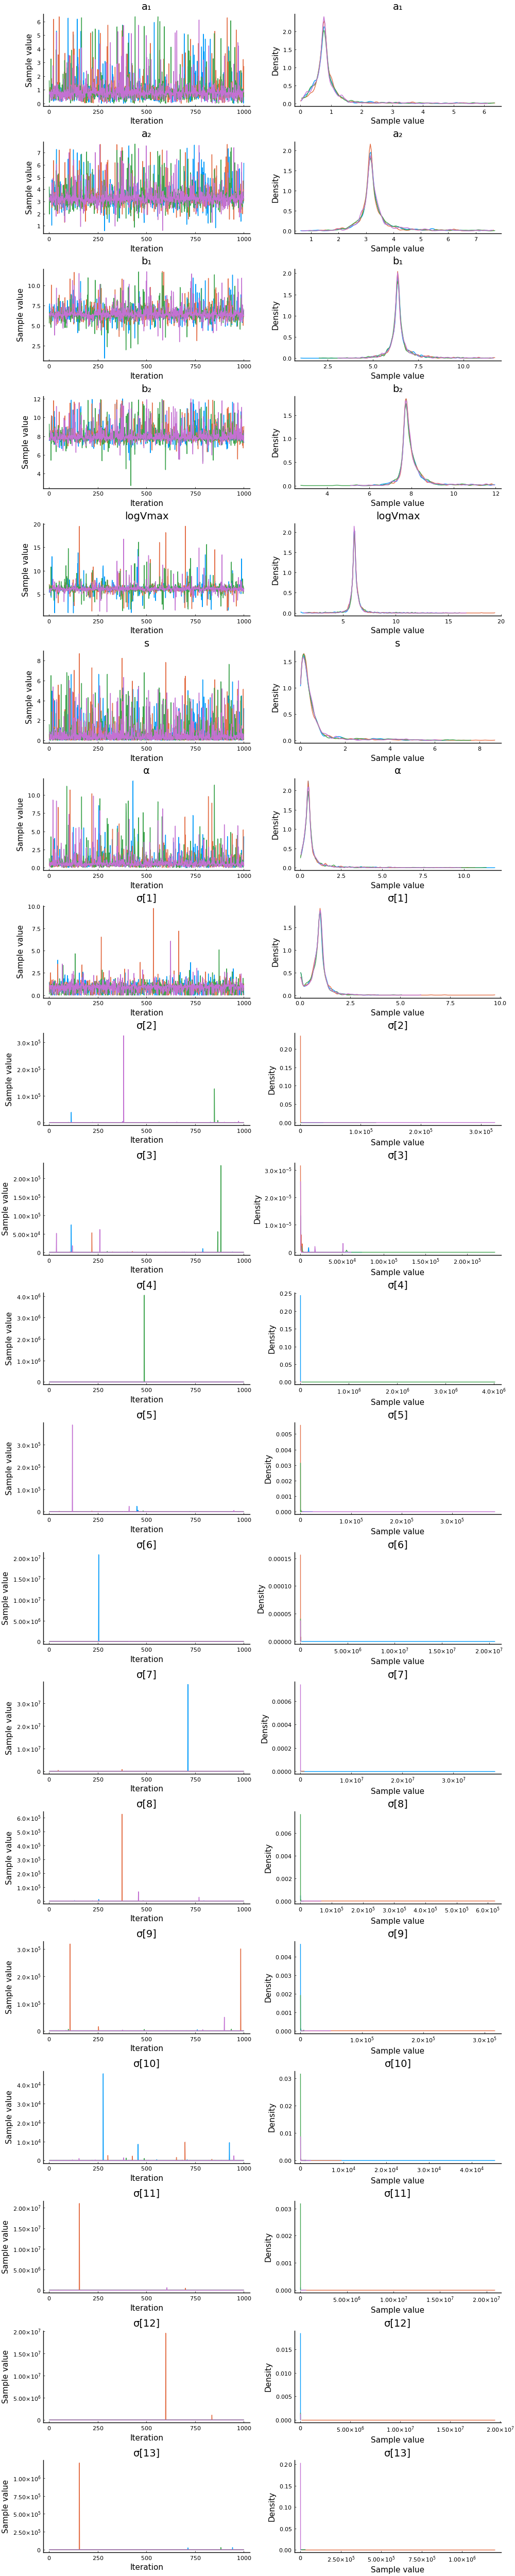

In [18]:
plot(chains)

Why are some $\sigma$ values so high?

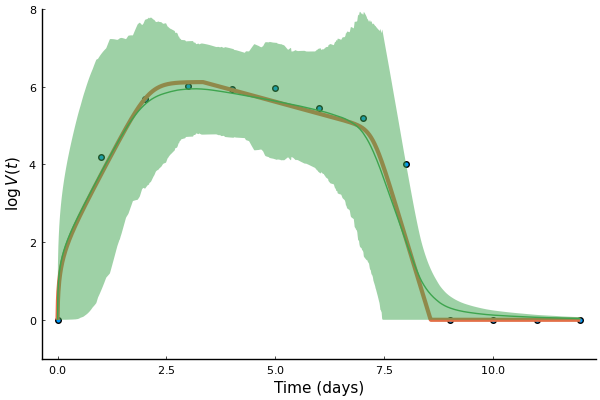

In [19]:
df = DataFrame(chains[:,:,1])[!, Symbol.(par_names)]
plot(ttdata, vvdata, seriestype=:scatter)
tt = [range(0., tend, step=1e-2);]
p = mean.(eachcol(df))
vv = LogVirusLoad.(tt, p...)
plot!(tt, vv, lw=3)
arr = [filter(!isnan, LogVirusLoad.(t, eachcol(df)...)) for t in tt]
m = [mean(v) for v in arr]
quantiles = [quantile(v, [0.05, 0.95]) for v in arr]
lower = [q[1] - m for (q, m) in zip(quantiles, m)]
upper = [q[2] - m for (q, m) in zip(quantiles, m)]
plot!(tt, m, ribbon = [lower, upper])
plot!(legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 8)))

**Sample from the predictive posterior distribution using a model each parameter and common variance for all time points.**

To compute predictive posterior values we need to use common variance

In [20]:
@model function VLFmodel(t, v, p₀)
    tmax = maximum(t)
    # Prior distributions
    s ~ Exponential(1.0)
    a₁ ~ truncated(Normal(p₀[1], s), 0, p₀[3])
    a₂ ~ truncated(Normal(p₀[2], s), a₁, p₀[4])
    b₁ ~ truncated(Normal(p₀[3], s), a₂, tmax)
    b₂ ~ truncated(Normal(p₀[4], s), b₁, tmax)
    α ~ truncated(Normal(p₀[5], s), 0, Inf)
    logVmax ~ truncated(Normal(p₀[6], s), 0, Inf)
    σ ~ LogNormal(0.0, 1.0)
    # Model
    for i ∈ eachindex(v)
        v[i] ~ Normal(LogVirusLoad(t[i], a₁, a₂, b₁, b₂, α, logVmax), σ)
    end
    return v
end

chains = mapreduce(c -> sample(VLFmodel(ttdata, vvdata, fit.minimizer), 
                   sampler, nsamples), chainscat, 1:nchains)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04


Chains MCMC chain (1000×10×4 Array{Float64, 3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
parameters        = a₁, a₂, b₁, b₂, logVmax, s, α, σ
internals         = logevidence, lp

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

          a₁    0.7600    0.3274     0.0052    0.0046   3761.3805    0.9999
          a₂    3.2842    0.5669     0.0090    0.0076   4297.5713    0.9994
          b₁    6.4526    0.6097     0.0096    0.0111   3700.7560    1.0013
          b₂    7.9775    0.5664     0.0090    0.0103   3701.6831    0.9999
     logVmax    6.1427    0.4513     0.0071    0.0082   4277.2811    1.0005
           s    0.4491    0.5377     0.0085    0.0084   3917.4399    0.9998
           α    0.6012    0.5974     0.0094    0.0089   4110.3215    1.0001
           σ    0.8261    0.5452     0.0086    0.

Sample for the posterior and predict, however, this does not include uncertainty from the data.

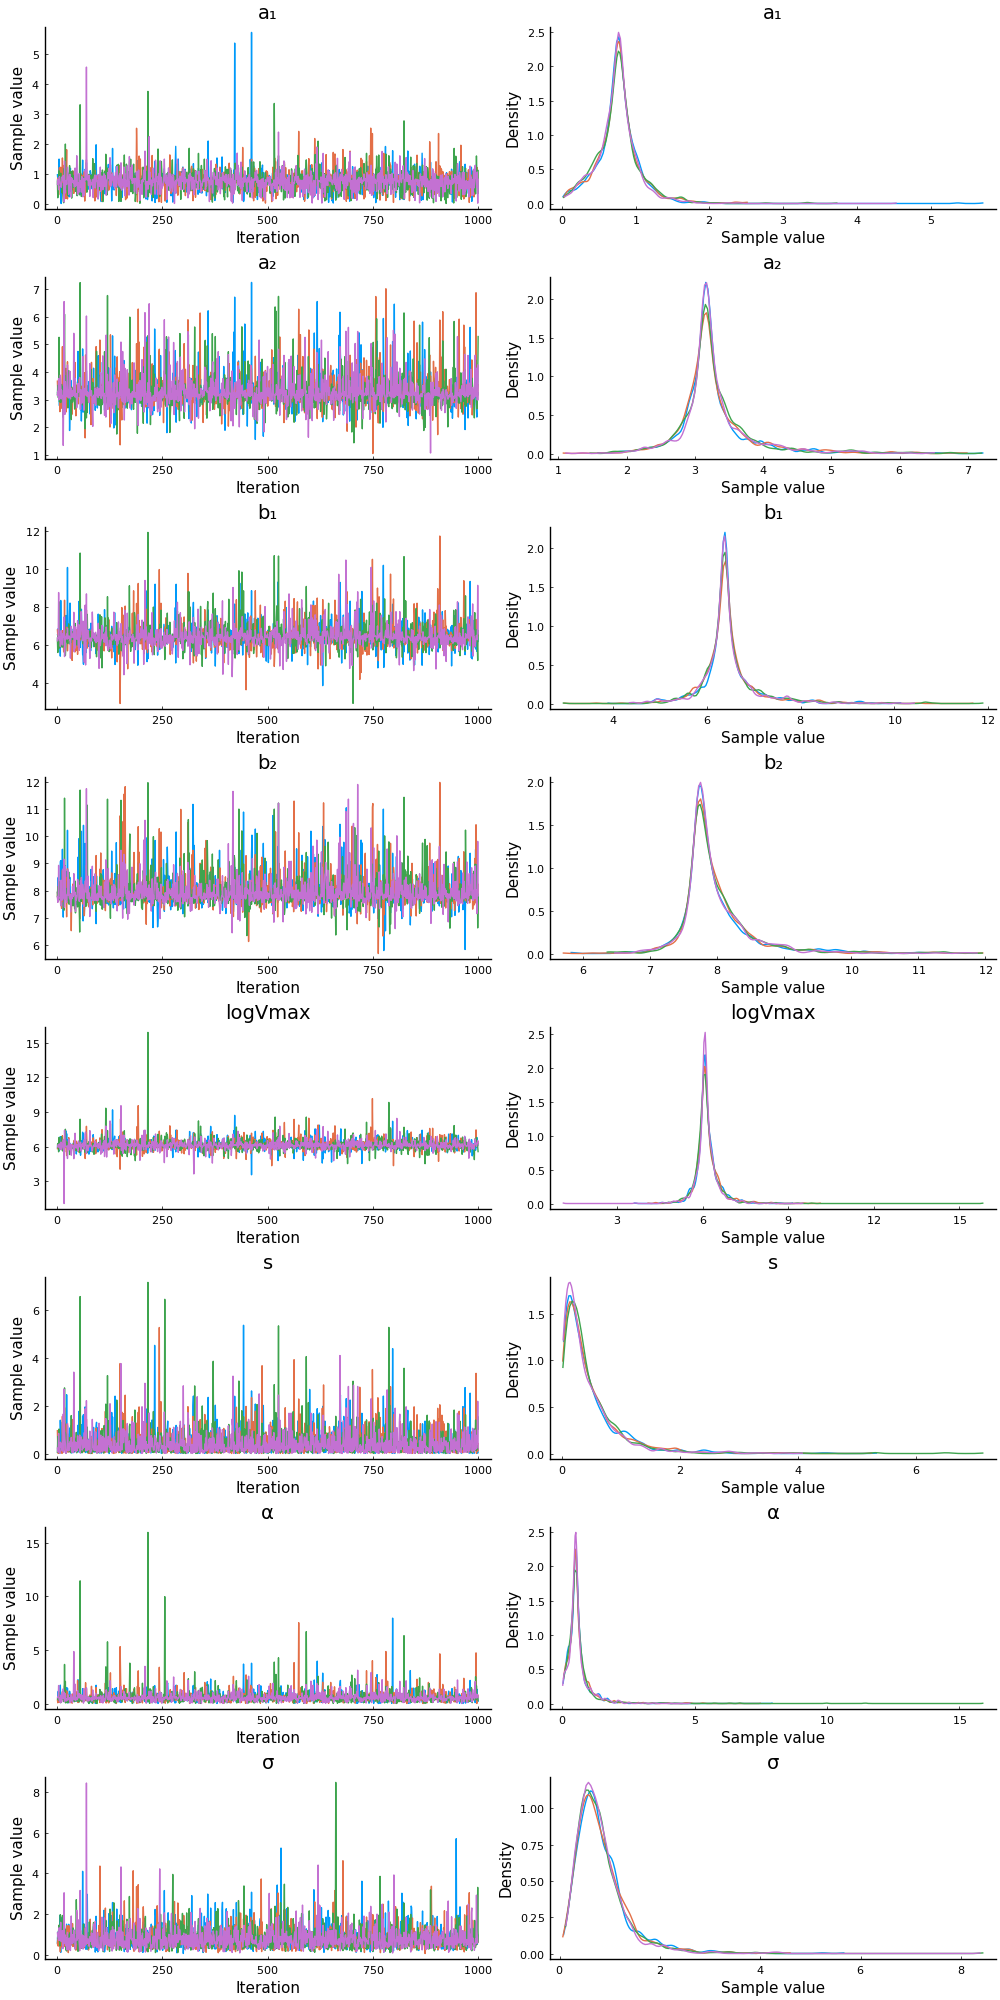

In [21]:
plot(chains)

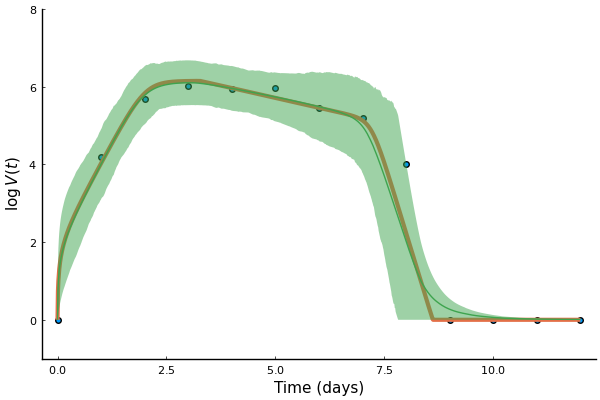

In [22]:
df = DataFrame(chains[:,:,1])[!, Symbol.(par_names)]
plot(ttdata, vvdata, seriestype=:scatter)
tt = [range(0., tend, step=1e-2);]
p = mean.(eachcol(df))
vv = LogVirusLoad.(tt, p...)
plot!(tt, vv, lw=3)
arr = [filter(!isnan, LogVirusLoad.(t, eachcol(df)...)) for t in tt]
m = [mean(v) for v in arr]
quantiles = [quantile(v, [0.05, 0.95]) for v in arr]
lower = [q[1] - m for (q, m) in zip(quantiles, m)]
upper = [q[2] - m for (q, m) in zip(quantiles, m)]
plot!(tt, m, ribbon = [lower, upper])
plot!(legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 8)))

In [23]:
predictions = predict(VLFmodel(tt, Vector{Union{Missing, Float64}}(undef, length(tt)), fit.minimizer), chains)

Chains MCMC chain (1000×1201×4 Array{Float64, 3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
parameters        = v[1], v[2], v[3], v[4], v[5], v[6], v[7], v[8], v[9], v[10], v[11], v[12], v[13], v[14], v[15], v[16], v[17], v[18], v[19], v[20], v[21], v[22], v[23], v[24], v[25], v[26], v[27], v[28], v[29], v[30], v[31], v[32], v[33], v[34], v[35], v[36], v[37], v[38], v[39], v[40], v[41], v[42], v[43], v[44], v[45], v[46], v[47], v[48], v[49], v[50], v[51], v[52], v[53], v[54], v[55], v[56], v[57], v[58], v[59], v[60], v[61], v[62], v[63], v[64], v[65], v[66], v[67], v[68], v[69], v[70], v[71], v[72], v[73], v[74], v[75], v[76], v[77], v[78], v[79], v[80], v[81], v[82], v[83], v[84], v[85], v[86], v[87], v[88], v[89], v[90], v[91], v[92], v[93], v[94], v[95], v[96], v[97], v[98], v[99], v[100], v[101], v[102], v[103], v[104], v[105], v[106], v[107], v[108], v[109], v[110], v[111], v[112], v[113], v[114], v[115], v[116], v[1

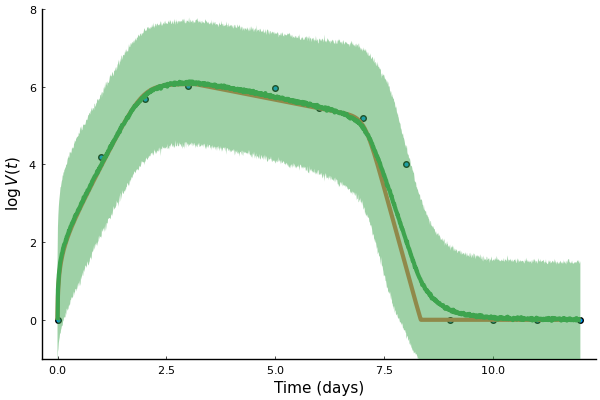

In [24]:
plot(ttdata, vvdata, seriestype=:scatter)
plot!(tt, LogVirusLoad.(tt, fit.minimizer...), lw=3)
arr = Array(group(predictions, :v))
m =  [mean(v) for v in eachcol(arr)]
quantiles = [quantile(v, [0.05, 0.95]) for v in eachcol(arr)]
lower = [q[1] - m for (q, m) in zip(quantiles, m)]
upper = [q[2] - m for (q, m) in zip(quantiles, m)]
plot!(tt, m, lw=3, ribbon = [lower, upper])
plot!(legend=:none, grid=:off,
    xaxis = ("Time (days)"),
    yaxis = (L"$\log\, V(t)$", (-1, 8)))

In [ ]:
@model function VLFNLMELSM(t, v, fit)
    # For each time point t[i], v[i] is a vector of observations
    # For now t and v have the same size, i.e. one obseravtion por time point
    tmax = maximum(t)
    p₀ = fit.minimizer
    # Prior distributions
    s ~ Exponential(1.0)
    a₁ ~ truncated(Normal(p₀[1], s), 0, tmax)
    a₂ ~ truncated(Normal(p₀[2], s), a₁, tmax)
    b₁ ~ truncated(Normal(p₀[3], s), a₂, tmax)
    b₂ ~ truncated(Normal(p₀[4], s), b₁, tmax)
    α ~ truncated(Normal(p₀[5], s), 0, Inf)
    logVmax ~ truncated(Normal(p₀[6], s), 0, Inf)
    σ ~ MvLogNormal(zero(v), s)
    # Model
    p = [a₁, a₂, b₁, b₂, α, logVmax]
    for i ∈ eachindex(v)
        v[i] ~ Normal(LogVirusLoad(t[i], p), σ[i])
    end
    return v
end

k = 1
ttdata = tdata
vvdata = data[k, :]
# ttdata = repeat(tdata, inner=10)
# vvdata = reshape(data, 1, :)[:];

tend = ttdata[end]

chains_prior = mapreduce(c -> sample(VLFmodel(ttdata, vvdata, fit), 
                         Prior(), nsamples), chainscat, 1:nchains)
chains = mapreduce(c -> sample(VLFmodel(ttdata, vvdata, fit), 
                   sampler, nsamples), chainscat, 1:nchains)

## Figures for the paper

In [29]:
Plots.scalefontsizes(1/1.4)

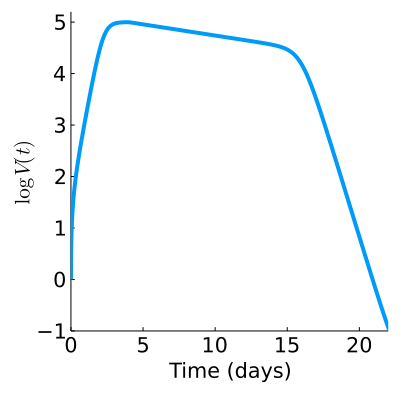

In [30]:
tend = 25.
par = [0.5,
       4.0,
       13.0,
       19.0,
       0.1,
       -6.0,
       5.0]
tt = Vector(range(0., tend, step=1e-2))
vv = LogVirusLoad(tt, par)
pt = plot(tt, vv, lw=4,
    legend=:none, grid=:off, size=(400, 400),
    xaxis = ("Time (days)", (0., 22.), font(14)),
    yaxis = (L"$\log\, V(t)$", (-1, 5.2), font(14)))
savefig("figures/VirusLoadLog.pdf")
savefig("figures/VirusLoadLog.png")
display(pt)

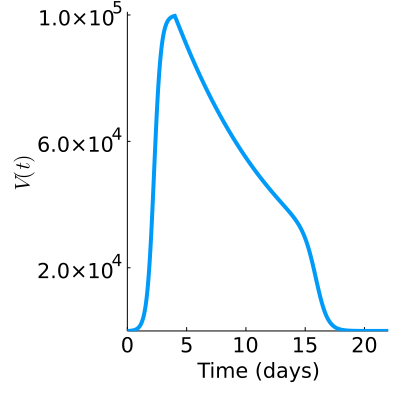

In [31]:
pt = plot(tt, 10.0.^vv, lw=4,
    legend=:none, grid=:off, size=(400, 400),
    xaxis = ("Time (days)", (0., 22.), font(14)),
    yaxis = (L"$V(t)$", (0, 1.01e5), font(14), [2e4, 6e4, 10e4]))
savefig("figures/VirusLoad.pdf")
savefig("figures/VirusLoad.png")
display(pt)

In [93]:
@model function gdemo(x, y)
    s ~ InverseGamma(2, 3)
    m ~ Normal(0, sqrt(s))
    x ~ Normal(m, sqrt(s))
    y ~ Normal(m, sqrt(s))
    return x, y
end

gdemo (generic function with 1 method)

In [95]:
gsample = gdemo(missing, missing)
gsample()

(-4.054840812303553, -0.9003629759754586)

In [104]:
plot(sample(gdemo(1.5, 2), Prior(), 10000))

<!DOCTYPE html>
 
 
 Plots.jl